### Installing necessary packages


In [1]:
# !pip install --upgrade pip
# !pip install transformers datasets faiss-cpu -q
# !pip install datasets

In [2]:
#Mount Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
from transformers import AutoFeatureExtractor, AutoModel
from datasets import load_dataset, concatenate_datasets, load_from_disk
from PIL import Image
import numpy as np
import os

c:\Users\ravik\Ravi\Projects\Gold_ImageSimilarity\enve\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
model_ckpt = "google/vit-base-patch16-224"

extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

hidden_dim = model.config.hidden_size

c:\Users\ravik\Ravi\Projects\Gold_ImageSimilarity\enve\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import os


fileDir = os.path.dirname(os.path.realpath('__file__'))
train_path= fileDir+'/datasets/train'
train_path

'C:\\Users\\ravik\\Ravi\\Projects\\Gold_ImageSimilarity/datasets/train'

In [8]:
# load training dataset from Google Drive
dataset = load_dataset("imagefolder", data_dir=train_path)

candidate_dataset = dataset['train']

In [9]:
# resize all PIL images to 224x224
for i, example in enumerate(candidate_dataset):
    candidate_dataset[i]['image'] = example['image'].resize((224, 224), Image.BILINEAR)

In [10]:
# labels to names mapping for visualization purposes
folder_names = candidate_dataset.features['label'].names
print(folder_names)

['Bracelets', 'Kasumalai', 'Rings']


In [11]:
# assign labels to the images from the folder names
labels_to_names = {i: folder_names[i] for i in range(len(folder_names))}

labels_to_names

{0: 'Bracelets', 1: 'Kasumalai', 2: 'Rings'}

In [12]:
#Extract embeddings
def extract_embeddings(image):
    image_pp = extractor(image, return_tensors="pt")
    features = model(**image_pp).last_hidden_state[:, 0].detach().numpy()
    return features.squeeze()

##### Creating hashes for the embeddings using FAISS and saving the index

In [13]:
dataset_with_embeddings = candidate_dataset.map(lambda example: {'embeddings': extract_embeddings(example["image"])})

# save dataset with embeddings variable to disk
dataset_with_embeddings.save_to_disk('old_embeddings')

# load dataset with embeddings from disk
dataset_with_embeddings.add_faiss_index(column='embeddings')

# save the faiss index to disk
dataset_with_embeddings.save_faiss_index('embeddings', 'old_index.faiss')

100%|██████████| 1/1 [00:00<00:00, 945.30it/s]


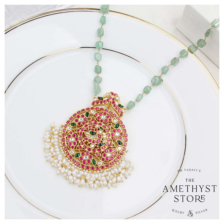

In [26]:
# load query_image from input path
query_image = Image.open(r'C:\Users\ravik\Ravi\Projects\Gold_ImageSimilarity\datasets\Kasumalai\Long Necklace\4.jpg')

# resize query image to 224x224 (if required)
query_image = query_image.resize((224, 224), Image.BILINEAR)
# query_image = query_image.rotate(90, Image.NEAREST, expand = 1)

query_image

In [27]:
def get_neighbors(query_image, top_k=5):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples

In [28]:
def get_neighbors(query_image, top_k=5):
    qi_embedding = model(**extractor(query_image, return_tensors="pt"))
    qi_embedding = qi_embedding.last_hidden_state[:, 0].detach().numpy().squeeze()
    scores, retrieved_examples = dataset_with_embeddings.get_nearest_examples('embeddings', qi_embedding, k=top_k)
    return scores, retrieved_examples


In [29]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

[714.3513  779.33356 779.51575 801.3201  801.7909 ]


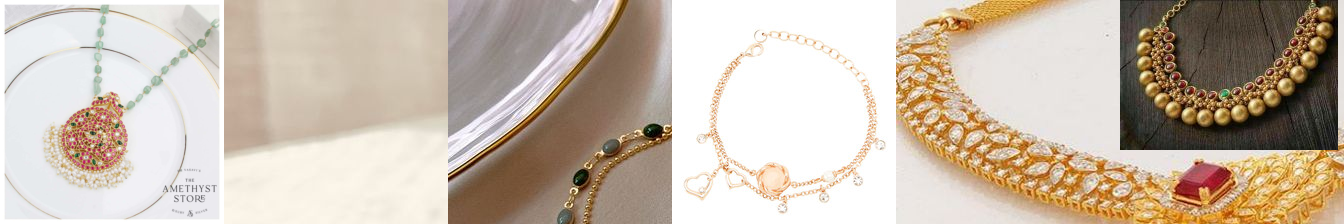

In [30]:
scores, retrieved_examples = get_neighbors(query_image)
images = [query_image]
images.extend(retrieved_examples["image"])
print(scores)
image_grid(images, 1, len(images))


In [31]:
# print names of retrieved images
names = np.array(retrieved_examples['label'])

## Logic for finding the majority label: Select the label that occurs the most number of times and if there is a tie, select the first one with higher similarity score
print()
if labels_to_names[names[0]] != labels_to_names[np.argmax(np.bincount(names))]:
    print(labels_to_names[names[0]])
else:
    print(labels_to_names[np.argmax(np.bincount(names))])


Bracelets
